In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from scipy import misc

train_dir = 'DataSet/UnsupVideo_Frames'
fold_index = '/00001/'
gnd_truth_dir = 'DataSet/UnsupVideo_Segments' 

def file_name(file_dir): 
    for root, dirs, files in os.walk(file_dir):
        #print(root) #当前目录路径
        #print(dirs) #当前路径下所有子目录
        #print(files) #当前路径下所有非目录子文件
        return files
        
def get_image(dir):
    img = mpimg.imread(dir)
    img_256 = misc.imresize(img,(256,256))
    plt.imshow(img_256)
    return img_256

def get_transform(img,lis):
    print(img.shape)
    mat = np.matrix(img)
    ans = lis
    (M,N) = mat.shape
    ans.append(mat[0:256,0:256])
    ans.append(mat[0:256,N-256:N])
    ans.append(mat[M-256:M,0:256])
    ans.append(mat[M-256:M,N-256:N])
    return ans


/home/sz2772/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


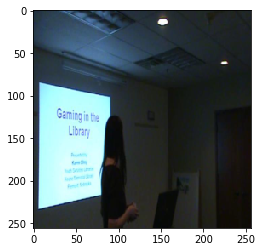

In [2]:
img = get_image(train_dir+fold_index+'2423313000_0_10.jpg')
mat = np.matrix(img[:,:,1])
#print(mat.shape)

/home/sz2772/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


0.0%
10.070493454179255%
20.14098690835851%
30.211480362537763%
40.28197381671702%
50.35246727089627%
60.42296072507553%
70.49345417925478%
80.56394763343404%
90.6344410876133%


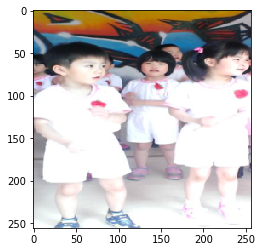

In [17]:
names = file_name(train_dir+fold_index)
number = len(names)
train_set = torch.zeros(number*5,3,224,224)

for i in range(0,len(names)):
    (M,N) = get_image(train_dir+fold_index+names[i])[:,:,1].shape
    a = torch.Tensor(get_image(train_dir+fold_index+names[i])[:,:,1])[0:224,0:224]
    if i%100==0:
        print(str(i/len(names)*100)+"%")
    for rgb in range(0,3):
        train_set[i*5,rgb,:,:] = torch.Tensor(get_image(train_dir+fold_index+names[i])[:,:,rgb])[0:224,0:224]
        train_set[i*5+1,rgb,:,:] = torch.Tensor(get_image(train_dir+fold_index+names[i])[:,:,rgb])[0:224,N-224:N]
        train_set[i*5+2,rgb,:,:] = torch.Tensor(get_image(train_dir+fold_index+names[i])[:,:,rgb])[M-224:M,0:224]
        train_set[i*5+3,rgb,:,:] = torch.Tensor(get_image(train_dir+fold_index+names[i])[:,:,rgb])[M-224:M,N-224:N]
        train_set[i*5+4,rgb,:,:] = torch.Tensor(get_image(train_dir+fold_index+names[i])[:,:,rgb])[int(M/2)-112:112+int(M/2),int(N/2)-112:112+int(N/2)]


/home/sz2772/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


0.0%
10.070493454179255%
20.14098690835851%
30.211480362537763%
40.28197381671702%
50.35246727089627%
60.42296072507553%
70.49345417925478%
80.56394763343404%
90.6344410876133%


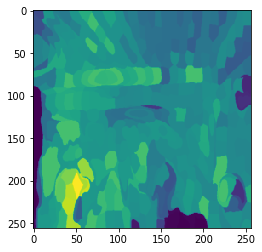

In [18]:
names = file_name(gnd_truth_dir+fold_index)
number = len(names)
true_set = torch.zeros(number*5,224,224)

for i in range(0,len(names)):
    (M,N) = get_image(gnd_truth_dir+fold_index+names[i])[:,:].shape
    if i%100==0:
        print(str(i/len(names)*100)+"%")
    true_set[i*5,:,:] = torch.Tensor(get_image(gnd_truth_dir+fold_index+names[i]))[0:224,0:224]
    true_set[i*5+1,:,:] = torch.Tensor(get_image(gnd_truth_dir+fold_index+names[i]))[0:224,N-224:N]
    true_set[i*5+2,:,:] = torch.Tensor(get_image(gnd_truth_dir+fold_index+names[i]))[M-224:M,0:224]
    true_set[i*5+3,:,:] = torch.Tensor(get_image(gnd_truth_dir+fold_index+names[i]))[M-224:M,N-224:N]
    true_set[i*5+4,:,:] = torch.Tensor(get_image(gnd_truth_dir+fold_index+names[i]))[int(M/2)-112:112+int(M/2),int(N/2)-112:112+int(N/2)]

In [19]:
class AlexNet(nn.Module):
    def __init__(self,num_classes=224*224):
        super(AlexNet,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    def forward(self,x):
        x = self.feature_extraction(x)
        x = x.view(x.size(0),256*6*6)
        x = self.classifier(x)
        return x

In [20]:
model = AlexNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
print(model)


input = train_set
out = model(input)
print(out.shape)

AlexNet(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)

In [6]:
batch_size = 50

# send model to GPU
model.cuda()

model.train() # to set train mode for drop out
train_loss, train_accu = [], []
i = 0
for epoch in range(45):
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

NameError: name 'model' is not defined